In [1]:
import numpy as np

from blackjack_env import BlackjackEnv
from utils import monte_carlo_policy_evaluation, plot_blackjack_values_wireframe

## **Example**

In [2]:
env = BlackjackEnv()

state_ranges = env.get_state_ranges()
state_ranges

{'player_sum': (4, 21), 'dealer_showing': (1, 10), 'usable_ace': (0, 1)}

In [3]:
policy = np.ones(shape=(22, 11, 2), dtype=float) * env.HIT # alway HIT
policy[[20, 21], :, :] = env.STICK # STICK when player_sum is 20 or 21

In [4]:
value_snapshots = monte_carlo_policy_evaluation(env, policy, max_iterations=500000, check_iters=[10000, 500000], verbose=True)

Completed 50000 episodes (10%)
Completed 100000 episodes (20%)
Completed 150000 episodes (30%)
Completed 200000 episodes (40%)
Completed 250000 episodes (50%)
Completed 300000 episodes (60%)
Completed 350000 episodes (70%)
Completed 400000 episodes (80%)
Completed 450000 episodes (90%)
Completed 500000 episodes (100%)


## **Visualize**

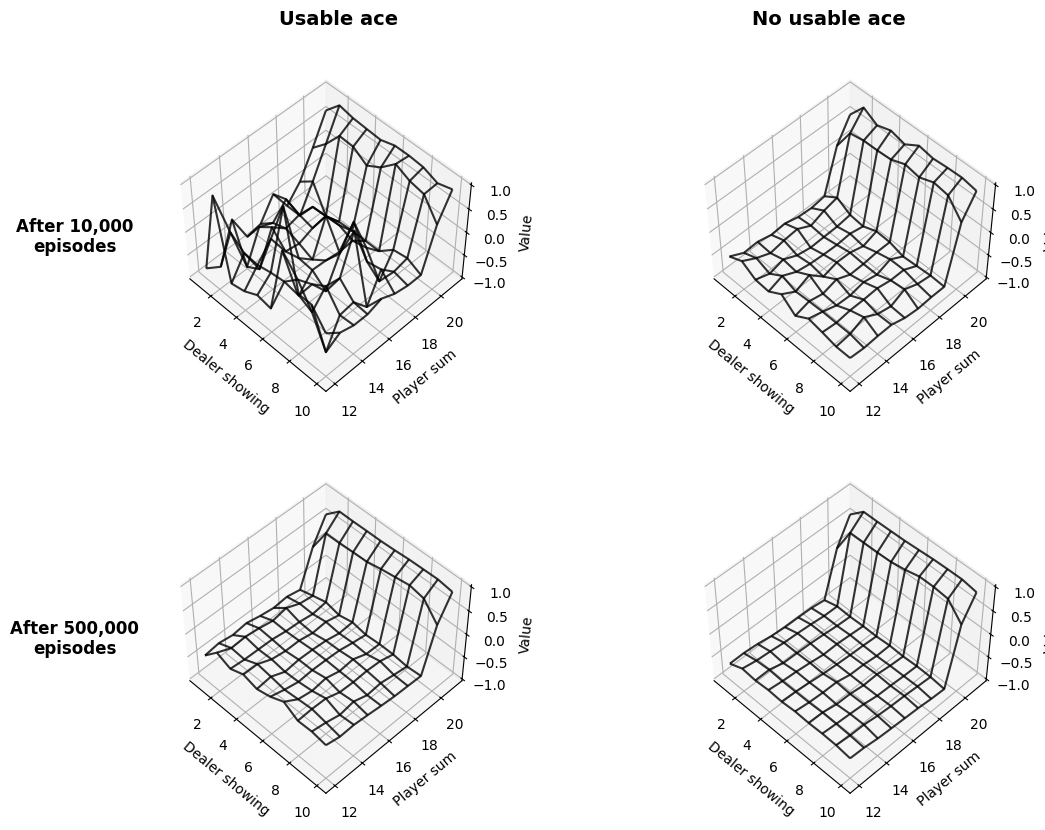

In [5]:
plot_blackjack_values_wireframe(value_snapshots)